deadline: 02.February.2022 12 PM. 

general tasks for this assignment are:

  - Import the dataset and prepare the data for the models (preferably using an automated loop)
  - Use all 5 cryptocurrencies
  - Generate feature variables from the data sets
  - Design neural networks which fit the task you are facing (predicting the target variable)
  - automatic optimization of the networks (for example with cross-validation, hyperparameter tuning, etc.)

dataset: [Kaggle](https://www.kaggle.com/c/g-research-crypto-forecasting)






# Team information

|Team-number :| 15|
|:----:|:----:|


|Name|    E-Mail        |matriculation-nr.|
|:----:|:----:|:----:|
|Sababa Saad Usmani| usmani01@ads.uni-passau.de|109409|
|Stegner Maria| Student3@uni-passau.de|3234567|
|Michael Haas| haas38@ads.uni-passau.de|78887|

# Data Import

In the following chapter we will import the basic data set. 

To do so we are using: 

> The os package, which provides a portable way of using operating system dependent functionality. This is necessary as we are going to manipulate file paths in order to read the data.

> The numpy packge, which provides operations on arrays, including mathematical, logical, shape manipulation, sorting, selecting, I/O, basic linear algebra and much more. We use this in this section especially to define datatypes for our datasample.

> The pandas package, which is usually used for data analysis and manipulation. This package allows us to read the csv file, to transform our index into datetime format and to merge different datasets.

In the first step we need to import the data by using pandas. Therefore we initially set the directory variable to the folder that contains our data and afterwards use os.path.join to join the dataset_name with the directory link. Before reading the dataset we define the datatypes using np.int and np.float, then we read the csv data and pass the datatypes to the dtype parameter. 

Since the timestamps are in seconds since the first of january 1970, we create a column in our datasample that contains the date in a datetime format. 

After preparing the dataset with the training data we also read the asset_details with pandas in the same fashion as before.

In the end we merge both dataframes on the basis of the Asset_ID column. 

In [2]:
import os
import numpy as np
import pandas as pd

#import data
directory = "../g-research-crypto-forecasting" 
file_path = os.path.join(directory, 'train.csv')
dtypes={
    'timestamp': np.int64,
    'Asset_ID': np.int8,
    'Count': np.int32,
    'Open': np.float64,
    'High': np.float64,
    'Low': np.float64,
    'Close': np.float64,
    'Volume': np.float64,
    'VWAP': np.float64,
    'Target': np.float64,
}
data = pd.read_csv(file_path, dtype=dtypes, usecols=list(dtypes.keys()))
data ['Time']=pd.to_datetime(data['timestamp'], unit='s')

file_path = os.path.join(directory, 'asset_details.csv')
details = pd.read_csv(file_path)

data = pd.merge(data, 
                details, 
                on ="Asset_ID",
                how = 'left')

We also split the data set so that we only work with the data that is available unti; 31-05-2021 and use the data beginning at 01-06-2021 to predict and evaluate the models.

In [3]:
print(data.head())

    timestamp  Asset_ID  Count        Open        High         Low  \
0  1514764860         2     40   2376.5800   2399.5000   2357.1400   
1  1514764860         0      5      8.5300      8.5300      8.5300   
2  1514764860         1    229  13835.1940  14013.8000  13666.1100   
3  1514764860         5     32      7.6596      7.6596      7.6567   
4  1514764860         7      5     25.9200     25.9200     25.8740   

        Close       Volume          VWAP    Target                Time  \
0   2374.5900    19.233005   2373.116392 -0.004218 2018-01-01 00:01:00   
1      8.5300    78.380000      8.530000 -0.014399 2018-01-01 00:01:00   
2  13850.1760    31.550062  13827.062093 -0.014643 2018-01-01 00:01:00   
3      7.6576  6626.713370      7.657713 -0.013922 2018-01-01 00:01:00   
4     25.8770   121.087310     25.891363 -0.008264 2018-01-01 00:01:00   

     Weight        Asset_Name  
0  2.397895      Bitcoin Cash  
1  4.304065      Binance Coin  
2  6.779922           Bitcoin  
3  1.3

#Splitting the Data
Training Set 
Validation Set 
Test Set 

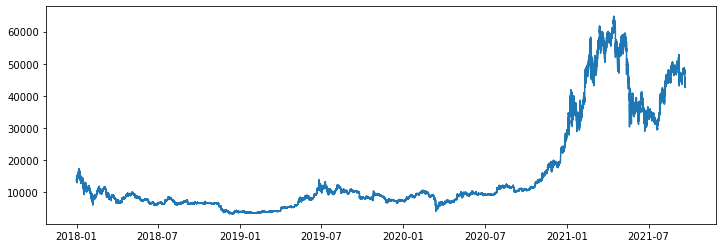

In [4]:
import matplotlib.pylab as plt


btc = data[data.Asset_ID == 1]
btc.set_index('timestamp', inplace = True)
btc = btc.reindex(range(btc.index[0], btc.index[-1] + 60, 60), method = 'pad')
btc.sort_index(inplace = True)

fig, ax = plt.subplots(figsize = (12, 4))

ax.plot(btc.Time, btc.Close)
plt.show()

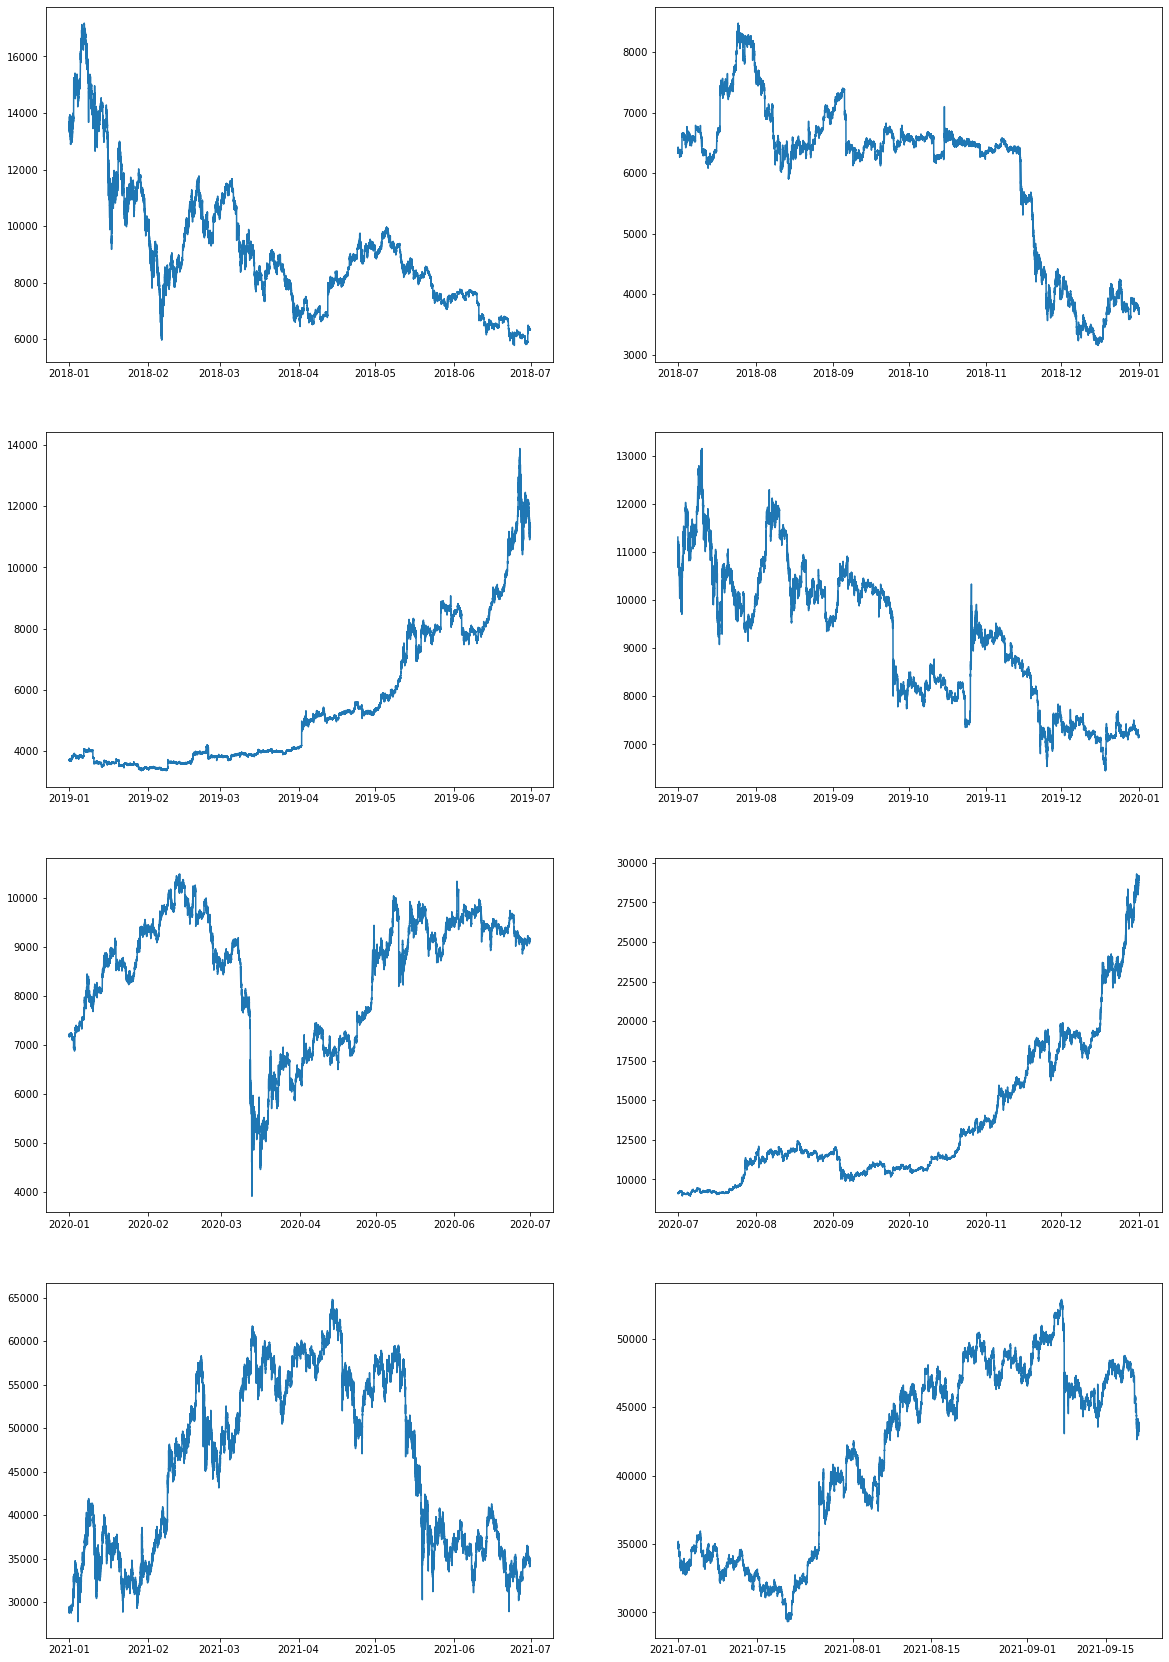

In [5]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

starting_date = btc.Time.iloc[0]
timesplits = [starting_date + i * relativedelta(months = 6) for i in range(8)] + [btc.Time.iloc[-1]]


import matplotlib.pyplot as plt

# Subplots are organized in a Rows x Cols Grid
# Tot and Cols are known
Tot = len(timesplits) - 1
Cols = 2

# Compute Rows required
Rows = Tot // Cols 
Rows += Tot % Cols

# Create a Position index
Position = range(1,Tot + 1)

# Create main figure
fig = plt.figure(1)
fig.set_figheight(30)
fig.set_figwidth(20)

for k in range(Tot):
  # add every single subplot to the figure with a for loop
    btc_tmp = btc.loc[datetime.timestamp(timesplits[k]):datetime.timestamp(timesplits[k+1])]
    ax = fig.add_subplot(Rows,Cols,Position[k])
    ax.plot(btc_tmp.Time, btc_tmp.Close)

plt.show()

# Generation of Technical Indicators

In the following chapter we will generate some technical indicators to use in our models. We do this here for the Bitcoin currency.

To do so we need the following package: 

(In this step you should be more precise regarding your package choice, extend your explanation with details that explain why you have chosen that specific package. This is not necessary for packages like pandas or numpy but would be necessary for something like ta) 

The Technical Analysis library, which can be used to do feature engineering from financial datasets containing time series data. 

We first seperate the code into two cells as the first one is solely used to install the ta package.


Now that the package is installed, we generate a variable that only contains the information about bitcoin. We therefore extract every row from the data variable that contains the Asset_ID corresponding to Bitcoin, set the index as timestamp and create a btc variable. 

Then we split our dataset into two sets test and training. We use a 70/30 approach for this. (Here you should obviously explain why you are choosing this approach)

Afterwards we calculate some technical indicators (you should obviously explain why you have chosen the indicators that you are using). 

We have chosen one Momentum Indicator in form of the Rate of Change (ROC). The Rate-of-Change (ROC) indicator, which is also referred to as simply Momentum, is a pure momentum oscillator that measures the percent change in price from one period to the next. The ROC calculation compares the current price with the price “n” periods ago. The plot forms an oscillator that fluctuates above and below the zero line as the Rate-of-Change moves from positive to negative. As a momentum oscillator, ROC signals include centerline crossovers, divergences and overbought-oversold readings. Divergences fail to foreshadow reversals more often than not, so this article will forgo a detailed discussion on them. Even though centerline crossovers are prone to whipsaw, especially short-term, these crossovers can be used to identify the overall trend. Identifying overbought or oversold extremes comes naturally to the Rate-of-Change oscillator. 

We have chosen one Volume Indicator in the form of Chaikin Money Flow (CMF). It measures the amount of Money Flow Volume over a specific period.

We have also chosen one Volatility Indicator in form of the Average True Range (ATR). The indicator provides an indication of the degree of price volatility. Strong moves, in either direction, are often accompanied by large ranges, or large True Ranges.

For all the indicators we use the same window of 5 Timesteps. (You also need to explain why you are using the timesteps that you are using in this example)
Because we are using five timesteps it the first five rows can not contain any data. Therefore we drop these rows from our example. 

In [6]:
!pip install ta

  Created wheel for ta: filename=ta-0.9.0-py3-none-any.whl size=28909 sha256=f2209e5c66941c14d26b5e59d9eab91b0f52fad3b160d556ca4c1bf90c661021
  Stored in directory: c:\users\micha\appdata\local\pip\cache\wheels\c4\71\30\9b87e7cc8350a4226ffbed6e4a6a923ac720845398895eb35d
Successfully built ta


In [18]:
#Split the data

#Training data
start_train, end_train = datetime.timestamp(timesplits[-9]), datetime.timestamp(timesplits[-3])
train_data = btc.loc[start_train:end_train][3600:]

#Validation data
start_val, end_val = datetime.timestamp(timesplits[-3]), datetime.timestamp(timesplits[-2])
val_data = btc.loc[start_val:end_val][3600:]

#Test Data
start_val, end_val = datetime.timestamp(timesplits[-2]), datetime.timestamp(timesplits[-1])
test_data = btc.loc[start_test:end_test][3600:]







In [ ]:
import ta

upper_shadow = lambda asset: asset.High - np.maximum(asset.Close,asset.Open)
lower_shadow = lambda asset: np.minimum(asset.Close,asset.Open)- asset.Low

#Training Data
train_data['close_1'] = train_data.Close.diff()
train_data['close_15'] = train_data.Close.diff(15)
train_data['close_60'] = train_data.Close.diff(60)

train_data['count_1'] = train_data.Count.diff()
train_data['count_15'] = train_data.Count.diff(15)
train_data['count_60'] = train_data.Count.diff(60)

train_data['volume_1'] = train_data.Volume.diff()
train_data['volume_15'] = train_data.Volume.diff(15)
train_data['volume_60'] = train_data.Volume.diff(60)

train_data['upper_shadow'] = upper_shadow(train_data)
train_data['lower_shadow'] = lower_shadow(train_data)

train_data = ta.add_all_ta_features(train_data,
                                       open = 'Open',
                                       high = 'High',
                                       low = 'Low',
                                       close = 'Close',
                                       volume = 'Volume',
                                       fillna = False)
#Validation Data
val_data['close_1'] = val_data.Close.diff()
val_data['close_15'] = val_data.Close.diff(15)
val_data['close_60'] = val_data.Close.diff(60)

val_data['count_1'] =val_data.Count.diff()
val_data['count_15'] = val_data.Count.diff(15)
val_data['count_60'] = val_data.Count.diff(60)

val_data['volume_1'] = val_data.Volume.diff()
val_data['volume_15'] = val_data.Volume.diff(15)
val_data['volume_60'] = val_data.Volume.diff(60)

val_data['upper_shadow'] = upper_shadow(val_data)
val_data['lower_shadow'] = lower_shadow(val_data)

val_data = ta.add_all_ta_features(val_data,
                                       open = 'Open',
                                       high = 'High',
                                       low = 'Low',
                                       close = 'Close',
                                       volume = 'Volume',
                                       fillna = False)


#Testing Data
test_data['close_1'] = test_data.Close.diff()
test_data['close_15'] = test_data.Close.diff(15)
test_data['close_60'] = test_data.Close.diff(60)

test_data['count_1'] = test_data.Count.diff()
test_data['count_15'] = test_data.Count.diff(15)
test_data['count_60'] = test_data.Count.diff(60)

test_data['volume_1'] = test_data.Volume.diff()
test_data['volume_15'] = test_data.Volume.diff(15)
test_data['volume_60'] = test_data.Volume.diff(60)

test_data['upper_shadow'] = upper_shadow(test_data)
test_data['lower_shadow'] = lower_shadow(test_data)

test_data = ta.add_all_ta_features(test_data,
                                       open = 'Open',
                                       high = 'High',
                                       low = 'Low',
                                       close = 'Close',
                                       volume = 'Volume',
                                       fillna = False)

# Delete variables with many missing values
train_data = train_data.drop(train_data.columns[train_data.isnull().sum() > 100], axis = 1)

val_data = val_data.drop(val_data.columns[val_data.isnull().sum() > 100], axis = 1)

test_data = test_data.drop(test_data.columns[test_data.isnull().sum() > 100], axis = 1)


find_corr_features = train_data.drop(['Asset_ID', 'Time', 'Weight'], axis = 1).corr(method = 'spearman')['Target'].abs().sort_values(ascending = False)
find_corr_features[1:21]

C:\Users\micha\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\micha\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


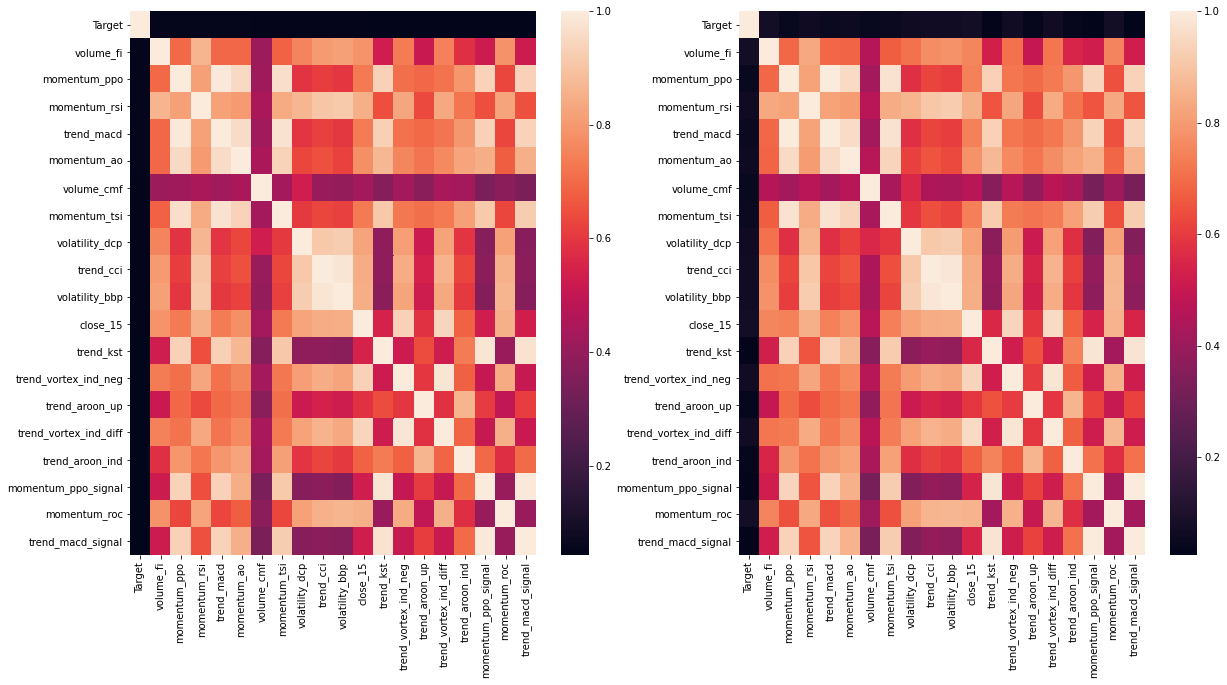

In [8]:
import seaborn as sns

train_data.dropna(inplace = True)
val_data.dropna(inplace = True)
test_data.dropna(inplace = True)

use_features = list(find_corr_features[:20].index)

fig, axs = plt.subplots(1, 3, figsize = (15, 7))
sns.heatmap(train_data[use_features].corr(method = 'spearman').abs(), ax = axs[0])
sns.heatmap(val_data[use_features].corr(method = 'spearman').abs(), ax = axs[0])
sns.heatmap(test_data[use_features].corr(method = 'spearman').abs(), ax = axs[1])
plt.show()

# Scaling of the data

Our data contains a wide variety of data that is based on different scales. For our neural network it is necessary to work with the same scale over every feature or target variable. 

To scale the data we are using the sklearn package, to be more precise the sklearn.preprocessing.MinMaxScaler method. This transforms features by scaling each feature to a given range. This estimator scales and translates each feature individually such that it is in the given range on the training set, as in this case zero and one. Before we can do that we need to drop the columns that contains non numerical data and the datetime datatype. After dropping the columns, we then transform the feature values. 

In [1]:
from sklearn.preprocessing import MinMaxScaler

X_scaler = MinMaxScaler(feature_range = (0, 1))
X_train = train_data[use_features].drop(['Target'], axis = 1)
X_val = val_data[use_features].drop(['Target'], axis = 1)
X_test = test_data[use_features].drop(['Target'], axis = 1)

y_train = train_data['Target'].values
y_test = test_data['Target'].values
y_val = val_data['Target'].values

X_train_ = X_scaler.fit_transform(X_train)
X_test_ = X_scaler.transform(X_test)
X_val_ = X_scaler.transform(X_val)

NameError: name 'train_data' is not defined

# Generating a Neural Network and Specifying the Baseline Model

Now that our data is prepared, we have generated our additional feature variables in form of technical indicators and our data is scaled to a uniformed scale we can start generating our neural network.

For the design of our neural network we are using the tensorflow package. To plot our loss functions we will also need matplotlib.

> Tensorflow is a foundation library that can be used to create Deep Learning models directly or by using wrapper libraries that simplify the process built on top of TensorFlow.

> Matplotlib is a comprehensive library for creating static, animated, and interactive visualizations in Python. Matplotlib makes simple requirements even more simpler and complex requirements possible to achieve.

We therefore import the tensorflow library into our code. Because we also want to use matplotlib we import the library into our code. 

We then create an input layer that has an input shape equally to the amount of columns of our data set or in other words the amount of features.

We then add a fully connected dense layer with 64 hidden neurons and a rectified linear unit (relu) activation function. (why?)

>The rectified linear activation function or ReLU for short is a piecewise linear function that will output the input directly if it is positive, otherwise, it will output zero. 

We then add another hidden layer with 32 hidden neurons and use the selu activation function. (why?)

>The Scaled Exponential Linear Unit (SELU) activation function is defined as:

>if x > 0: return scale * x

>if x < 0: return scale * alpha * (exp(x) - 1)

>where alpha and scale are pre-defined constants (alpha=1.67326324 and scale=1.05070098).

>Basically, the SELU activation function multiplies scale (> 1) with the output of the tf.keras.activations.elu function to ensure a slope larger than one for positive inputs.
The values of alpha and scale are chosen so that the mean and variance of the inputs are preserved between two consecutive layers as long as the weights are initialized correctly and the number of input units is "large enough".

As our last layer we add another densely connected layer that uses a linear activation function and returns exactly one output value. (you obviously should get into more detail regarding your choice for the architecture) 

As our next step we compile our network with the mean absolute error loss function and the adam optimizer. 

>The mean absolute error computes the mean of absolute difference between labels and predictions. 

>Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.

We afterwards fit our model with 15 epochs (why?) and a batch_size of 10000 (why?).
In the end we plot our loss and validation losses to see their courses.

To understand the real performance of our model we use scatterplots to display the drifting apart of the prediction and the real values. Additionaly we calculate the correlation between both values. 

In [ ]:

import matplotlib.pyplot as plt

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = (X_train_.shape[1])),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(32, activation = 'selu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1)
])

model.compile(loss = 'mean_absolute_error', optimizer = 'adam')
history = model.fit(X_train_, y_train, epochs = 15, batch_size = 100000, validation_data = (X_test_, y_test))
plt.plot(history.history['loss'], label = 'training')
plt.plot(history.history['val_loss'], label = 'test')
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (12,8))

axs[0].scatter(model.predict(X_train_).flatten(), y_train)
axs[1].scatter(model.predict(X_test_).flatten(), y_test)
plt.show()
print(np.corrcoef(model.predict(X_train_).flatten(), y_train)[0, 1])
print(np.corrcoef(model.predict(X_test_).flatten(), y_test)[0, 1])

# Hyperparameter Search
Now we use the Hyperparameter Search to optimize the parameters before specifying the NN. We tune model hyperparameters that influence model architecture (e.g., number and width of hidden layers) and algorithm hyperparameters that influence the speed and quality of training (e.g., learning rate and activation function). The number of hyperparameter combinations can grow insanely large causing a manual search for an optimal set simply not feasible nor scalable. Therefore we use Keras Tuner to automate the search. 


In [ ]:
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras

print(f"TensorFlow Version: {tf.__version__}")
print(f"KerasTuner Version: {kt.__version__}")
print(f"Keras Version: {keras.__version__}")

In [ ]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt


In [ ]:
# Number of epochs
NUM_EPOCHS = 5

def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28,28)))
    
    # Tune the number of hidden layers and units in each.
    # Number of hidden layers: 1 - 5
    # Number of Units: 32 - 512 with stepsize of 32
    for i in range(1, hp.Int("num_layers", 2, 6)):
        model.add(
            keras.layers.Dense(
                units=hp.Int("units_" + str(i), min_value=32, max_value=512, step=32),
                activation="relu")
            )
        
        # Tune dropout layer with values from 0 - 0.3 with stepsize of 0.1.
        model.add(keras.layers.Dropout(hp.Float("dropout_" + str(i), 0, 0.3, step=0.1)))
    
    # Add output layer.
    model.add(keras.layers.Dense(units=10, activation="softmax"))
    
    # Tune learning rate for Adam optimizer with values from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
    
    # Define optimizer, loss, and metrics
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss=keras.losses.SparseCategoricalCrossentropy(),
                  metrics=["accuracy"])
    
    return model


In [ ]:
# Instantiate the tuner
tuner = kt.Hyperband(build_model,
                     objective="val_accuracy",
                     max_epochs=5,
                     factor=3,
                     hyperband_iterations=10,
                     directory="kt_dir2",
                     project_name="kt_hyperband",)

# Display search space summary
tuner.search_space_summary()

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(X_val, y_val, epochs=NUM_EPOCHS, validation_split=0.2, callbacks=[stop_early], verbose=2)

# Get the optimal hyperparameters from the results
best_hps=tuner.get_best_hyperparameters()[0]

#Specify the optimized model
use the parameters from the hyperparameter search

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = (X_train_.shape[1])),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(32, activation = 'selu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(1)
])

model.compile(loss = 'mean_absolute_error', optimizer = 'adam')
history = model.fit(X_train_, y_train, epochs = 15, batch_size = 100000, validation_data = (X_test_, y_test))
plt.plot(history.history['loss'], label = 'training')
plt.plot(history.history['val_loss'], label = 'test')
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (12,8))

axs[0].scatter(model.predict(X_train_).flatten(), y_train)
axs[1].scatter(model.predict(X_test_).flatten(), y_test)
plt.show()
print(np.corrcoef(model.predict(X_train_).flatten(), y_train)[0, 1])
print(np.corrcoef(model.predict(X_test_).flatten(), y_test)[0, 1])

#Comparison Baseline Model and Optimized Model

# Making forecasts with the optimized model

Now that we have generated our model we want to test our model performance.
Therefore we predict values with our model on the basis of our data_eval. Therefore, we need to adjust our varible to the bitcoin_eval. We then generate the same technical indicators as for the training and test data and then prepare the data for our prediction, this means excluding string columns and the target variable. Then to show the performance we use a scatterplot and calculate the correleation between the predictions and the real values.

In [ ]:
btc_eval = data_eval[data_eval.Asset_ID == 1]
btc_eval.set_index('timestamp', inplace = True)

ROC = ta.momentum.ROCIndicator(close = btc_eval['Close'],window = 5,fillna=False)
btc_eval['ROC'] = ROC.roc()

CMF =ta.volume.ChaikinMoneyFlowIndicator(close = btc_eval['Close'],high = btc_eval['High'], low = btc_eval['Low'], volume = btc_eval['Volume'], window = 5,fillna=False)
btc_eval['CMF'] = CMF.chaikin_money_flow()

AVR =ta.volatility.AverageTrueRange(close = btc_eval['Close'],high = btc_eval['High'], low = btc_eval['Low'], window = 5,fillna=False)
btc_eval['AVR'] = AVR.average_true_range()

btc_eval.dropna(inplace = True)

X_eval = btc_eval.drop(['Asset_ID','Time','Weight','Asset_Name','Target'], axis = 1)
X_eval_ = X_scaler.transform(X_eval)
y_eval = btc_eval['Target'].values

plt.scatter(model.predict(X_eval_).flatten(), y_eval)
plt.show()
print(np.corrcoef(model.predict(X_eval_).flatten(), y_eval)[0, 1])

# Discussing the results

As we can see in our scatterplot our values of the prediction (x-axis) move on a far bigger span (-0.075 to 0.125) than the values of the real targets (-0.02 to 0.06). Additionally, our predictions tend to lie at around -0.025 and -0.075. In most cases, values which are below the lowest real value. Meanwhile, the real values tend to lie between -0.02 and 0.02 most of the time. These differences in values are also confirmed by our correlation coefficient which is basically 0.02. (Here you should also go into far more detail regarding your results, as this is just an example for your understanding).